In [1]:
import numpy as np
import pandas as pd
import glob
import pandas_profiling
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns



/usr/local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [9]:
os.chdir('..')
os.chdir('tuition_data/CollegeScorecard_Raw_Data')

In [11]:
csv_list = !ls

In [12]:
years = list(np.arange(1996, 2018))
years

[1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017]

In [13]:
df_list = [pd.read_csv(f, low_memory=False) for f in glob.glob('*.csv')]


In [14]:
year_list = list(np.arange(1996,2018))
len(year_list)

22

In [15]:

for index, df in enumerate(df_list):
    df['year'] = year_list[index]

In [16]:
df=pd.concat(df_list, ignore_index=True)

In [17]:
len(df)

154228

In [18]:
pd.to_pickle(df, 'big_ol_df.pkl')

In [19]:
!ls

Crosswalks           MERGED2003_04_PP.csv MERGED2012_13_PP.csv
Crosswalks.zip       MERGED2004_05_PP.csv MERGED2013_14_PP.csv
MERGED1996_97_PP.csv MERGED2005_06_PP.csv MERGED2014_15_PP.csv
MERGED1997_98_PP.csv MERGED2006_07_PP.csv MERGED2015_16_PP.csv
MERGED1998_99_PP.csv MERGED2007_08_PP.csv MERGED2016_17_PP.csv
MERGED1999_00_PP.csv MERGED2008_09_PP.csv MERGED2017_18_PP.csv
MERGED2000_01_PP.csv MERGED2009_10_PP.csv big_ol_df.pkl
MERGED2001_02_PP.csv MERGED2010_11_PP.csv data.yaml
MERGED2002_03_PP.csv MERGED2011_12_PP.csv linear.png


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154228 entries, 0 to 154227
Columns: 1978 entries, UNITID to year
dtypes: float64(624), int64(7), object(1347)
memory usage: 2.3+ GB


In [ ]:
# If you need to rerun everything, do it here
df = pd.read_csv('big_ol_df.pkl')

In [21]:
df_regression = df.loc[:, ['TUITFTE', 'INEXPFTE', 'AVGFACSAL',  'PCTPELL']]

In [22]:
df_regression

,TUITFTE,INEXPFTE,AVGFACSAL,PCTPELL
0,4626.0,6841.0,6460.0,0.6933
1,7289.0,16681.0,9420.0,0.3381
2,11969.0,4662.0,3500.0,0.6506
3,7264.0,9590.0,8482.0,0.3176
4,7220.0,7581.0,6794.0,0.7251
5,10179.0,10197.0,8822.0,0.2294
6,1679.0,5143.0,5498.0,0.6150
7,4356.0,5685.0,7333.0,0.3839
8,5991.0,5428.0,6763.0,0.4100
9,11043.0,10823.0,8808.0,0.1767


In [23]:
df_regression.isna().sum()

TUITFTE      20448
INEXPFTE     20453
AVGFACSAL    65930
PCTPELL      86844
dtype: int64

In [24]:
df_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154228 entries, 0 to 154227
Data columns (total 4 columns):
TUITFTE      133780 non-null float64
INEXPFTE     133775 non-null float64
AVGFACSAL    88298 non-null float64
PCTPELL      67384 non-null float64
dtypes: float64(4)
memory usage: 4.7 MB


In [25]:
df_no_na = df_regression.dropna()

In [26]:
df_no_na = df_no_na[df_no_na['TUITFTE'] < df_no_na['TUITFTE'].quantile(0.99)]

In [27]:
df_no_na.columns = ['tuition', 'instructional_exp', 'fac_salary', 'pct_pell']

In [28]:
df_no_na.replace(0, 0.01, inplace=True)

In [29]:
df_no_na

,tuition,instructional_exp,fac_salary,pct_pell
0,4626.00,6841.00,6460.0,0.6933
1,7289.00,16681.00,9420.0,0.3381
2,11969.00,4662.00,3500.0,0.6506
3,7264.00,9590.00,8482.0,0.3176
4,7220.00,7581.00,6794.0,0.7251
5,10179.00,10197.00,8822.0,0.2294
6,1679.00,5143.00,5498.0,0.6150
7,4356.00,5685.00,7333.0,0.3839
8,5991.00,5428.00,6763.0,0.4100
9,11043.00,10823.00,8808.0,0.1767


In [36]:
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# Create dataframes( or series) with predictors and  predicted values
X = df_no_na[['instructional_exp', 'fac_salary', 'pct_pell']]
y = df_no_na['tuition']
    
# Scale the data using Robust Scaler
scale = PowerTransformer(method='box-cox', standardize=False)
transformed = scale.fit_transform(X)
X = pd.DataFrame(transformed, columns = X.columns)

# Create Train and Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create a ridge regression model
ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train)

# Create predicted values
y_h_ridge_train = ridge.predict(X_train)
y_h_ridge_test = ridge.predict(X_test)

In [37]:
len(X_train['instructional_exp'])

30925

In [38]:
len(y_train)

30925

In [39]:
ridge.score(X_train, y_train)

0.13794620291147663

In [40]:
ridge.coef_

array([2461.45288765,   -6.27450546, 2774.60257556])

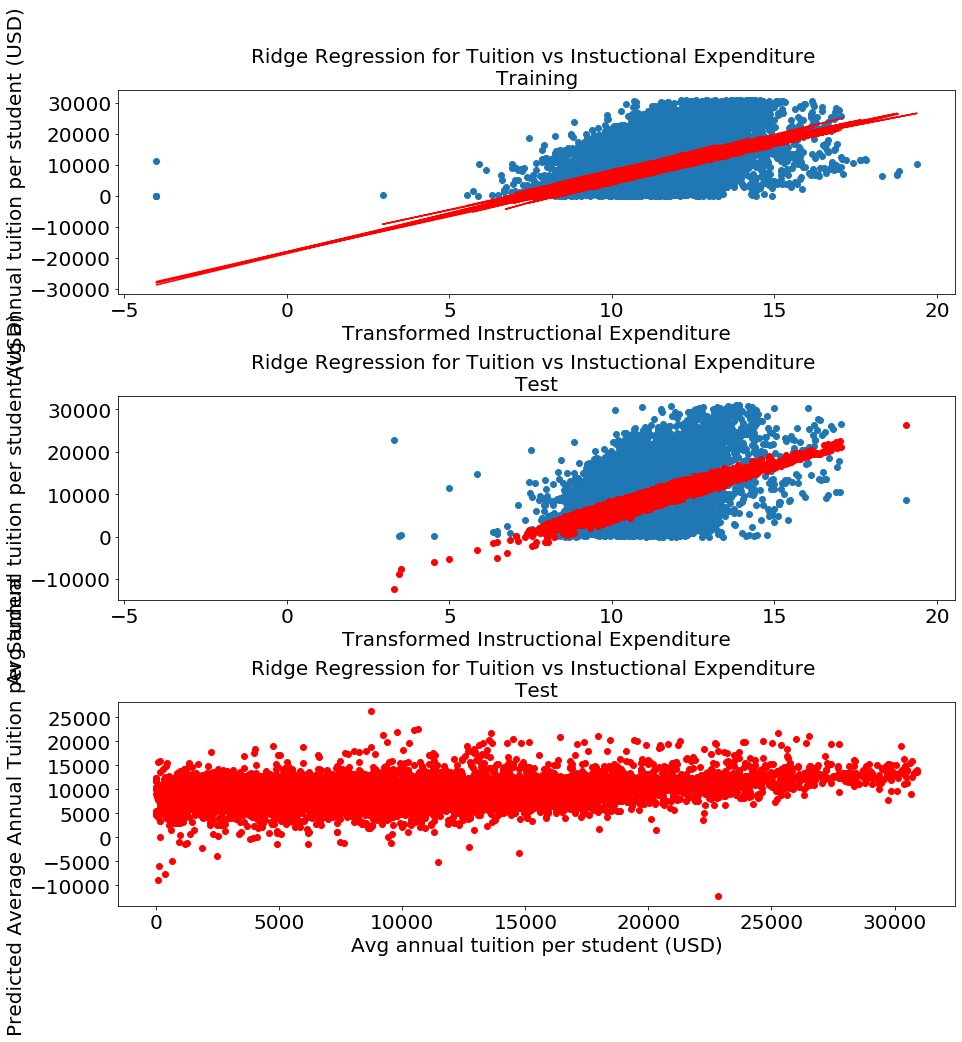

In [51]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
plt.title('Ridge Regression for Tuition vs Instuctional Expenditure \nTraining', fontsize=20)
#plt.text(5.5,30000,f'$R^2 = {round(ridge.score(X_train,y_train), 2)}$', fontsize=20)
plt.xlabel('Transformed Instructional Expenditure', fontsize = 20 )
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Avg annual tuition per student (USD)', fontsize=20)
plt.scatter(X_train['instructional_exp'], y_train)
plt.plot(X_train['instructional_exp'], y_h_ridge_train, color='red')

ax2 = fig.add_subplot(212, sharex=ax1)
plt.title('Ridge Regression for Tuition vs Instuctional Expenditure \nTest', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.text(5.5,15000,f'$R^2 = {round(ridge.score(X_test,y_test), 2)}$', fontsize=20)
plt.xlabel('Transformed Instructional Expenditure', fontsize = 20 )
plt.ylabel('Avg annual tuition per student (USD)', fontsize=20)
plt.scatter(X_test['instructional_exp'], y_test)
plt.scatter(X_test['instructional_exp'], y_h_ridge_test, color='red')


plt.subplots_adjust(hspace=0.5)
plt.savefig('linear.png')




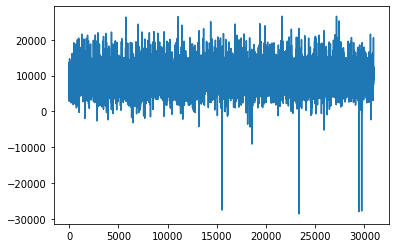

In [46]:
plt.plot(np.arange(0,len(y_h_ridge_train)), y_h_ridge_train)